In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

In [2]:
data = pd.read_csv("../../Data/wa/Data gede masked olahan.csv", parse_dates=['Date','Last Update Time'])
df = data.copy()
df.head()

C:\Users\Jayy\AppData\Local\Temp\ipykernel_3024\1192523660.py:1: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("../../Data/wa/Data gede masked olahan.csv", parse_dates=['Date','Last Update Time'])


,Email User,Nomor Telepon Tujuan,Status,Date,Last Update Time,jam last update,tanggal last update,hari last update,isWeekend last update,jam,tanggal,hari,Nomor Telepon Tujuan Prefix,provider,selisih
0,Email user 1,0821xxxxxxxx,read,2023-02-14 11:13:00,2023-02-14 11:14:00,11,14,Selasa,0,11,14,Selasa,0821,Telkomsel,0 days 00:01:00
1,Email user 1,0812xxxxxxxx,read,2023-02-14 11:13:00,2023-02-14 11:17:00,11,14,Selasa,0,11,14,Selasa,0812,Telkomsel,0 days 00:04:00
2,Email user 1,0838xxxxxxxx,read,2023-02-14 11:13:00,2023-02-14 11:15:00,11,14,Selasa,0,11,14,Selasa,0838,XL,0 days 00:02:00
3,Email user 1,0858xxxxxxxx,read,2023-02-14 11:13:00,2023-02-14 11:28:00,11,14,Selasa,0,11,14,Selasa,0858,Indosat,0 days 00:15:00
4,Email user 1,0858xxxxxxxx,delivered,2023-02-14 11:13:00,2023-02-14 11:13:00,11,14,Selasa,0,11,14,Selasa,0858,Indosat,0 days 00:00:00


In [3]:
df = df[(df['Status'] == 'read') | (df['Status'] == 'delivered')]

In [4]:
df['Status'].value_counts()

read         7048484
delivered    2257911
Name: Status, dtype: int64

In [5]:
df.dtypes

Email User                             object
Nomor Telepon Tujuan                   object
Status                                 object
Date                           datetime64[ns]
Last Update Time               datetime64[ns]
jam last update                         int64
tanggal last update                     int64
hari last update                       object
isWeekend last update                   int64
jam                                     int64
tanggal                                 int64
hari                                   object
Nomor Telepon Tujuan Prefix            object
provider                               object
selisih                                object
dtype: object

In [6]:
from sklearn.preprocessing import RobustScaler, MinMaxScaler, StandardScaler

In [7]:
groupby = df.groupby(["hari last update", "jam last update","tanggal last update", "Status"]).size().unstack().sort_values(by="read", ascending=False)
groupby.dropna(inplace=True)
groupby['total'] = groupby['read'] + groupby['delivered']
groupby['read_rate'] = groupby['read'] / (groupby['read'] + groupby['delivered'])


scaller = MinMaxScaler()
groupby['read scalled'] = scaller.fit_transform(groupby[['read']])
groupby['delivered scalled'] = scaller.fit_transform(groupby[['delivered']])
groupby['weighted'] = (groupby['delivered scalled'] * 0.001) + (groupby['read scalled'] * 0.999)

groupby.sort_values(by=['read_rate', 'weighted'], ascending=False)
groupby = groupby.reset_index()
groupby

Status,hari last update,jam last update,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted
0,Sabtu,13,25,31393.0,64446.0,95839.0,0.672440,1.000000,1.000000,1.000000
1,Sabtu,14,25,26926.0,61216.0,88142.0,0.694516,0.949880,0.857703,0.949788
2,Sabtu,12,25,30938.0,57539.0,88477.0,0.650327,0.892823,0.985506,0.892916
3,Sabtu,15,25,19051.0,52617.0,71668.0,0.734177,0.816448,0.606843,0.816239
4,Sabtu,16,25,19326.0,50905.0,70231.0,0.724822,0.789883,0.615603,0.789709
...,...,...,...,...,...,...,...,...,...,...
1967,Sabtu,14,29,1.0,3.0,4.0,0.750000,0.000031,0.000000,0.000031
1968,Senin,13,8,1.0,3.0,4.0,0.750000,0.000031,0.000000,0.000031
1969,Sabtu,2,22,2.0,2.0,4.0,0.500000,0.000016,0.000032,0.000016
1970,Rabu,0,26,2.0,2.0,4.0,0.500000,0.000016,0.000032,0.000016


In [8]:
# groupby['selisih'].value_counts()

In [9]:
# groupby['selisih'].str.slice(7,9).unique()

In [10]:
# groupby['selisih'] = groupby['selisih'].str.slice(7,9)
# groupby['selisih'].value_counts()

In [11]:
# # replace ar mmenjadi lebih dari satu hari dan 00 menjadi kurang dari satu jam
# groupby['selisih'] = groupby['selisih'].replace(['ar'], 'lebih dari satu hari')
# groupby['selisih'] = groupby['selisih'].replace(['00'], 'kurang dari satu jam')
# groupby['selisih'] = groupby['selisih'].astype('str')

# groupby['selisih'].value_counts()

In [12]:
# mapping_selisih = {
#     'kurang dari satu jam': "kurang dari satu jam",
#     '01' : "1 jam",
#     '02' : "2 jam",
#     '03' : "3 jam",
#     '04' : "4 jam",
#     '05' : "5 jam",
#     '06' : "6 jam",
#     '07' : "7 jam",
#     '08' : "8 jam",
#     '09' : "9 jam",
#     '10' : "10 jam",
#     '11' : "11 jam",
#     '12' : "12 jam",
#     '13' : "13 jam",
#     '14' : "14 jam",
#     '15' : "15 jam",
#     '16' : "16 jam",
#     '17' : "17 jam",
#     '18' : "18 jam",
#     '19' : "19 jam",
#     '20' : "20 jam",
#     '21' : "21 jam",
#     '22' : "22 jam",
#     '23' : "23 jam",
#     'lebih dari satu hari' : "lebih dari satu 24 jam"
# }

# groupby['selisih'] = groupby['selisih'].map(mapping_selisih)
# groupby['selisih'].value_counts()

In [13]:
# groupby[groupby['selisih'] == '20 jam']

In [14]:
def is_weekend(groupby):
    
    if (
        groupby['hari last update'] == 'Sabtu' 
        or groupby['hari last update'] == 'Minggu'
        ):
        return 'Weekend'
    else:
        return 'Weekday'

groupby['is_weekend'] = groupby.apply(is_weekend, axis = 1)

In [15]:
def is_working_hour(groupby):
    if (
        groupby['jam last update'] >= 8 
        and groupby['jam last update'] <= 17
        and groupby['is_weekend'] == 'Weekday'
        ):
        return 'Working Hour'
    else:
        return 'Non Working Hour'

groupby['is_working_hour'] = groupby.apply(is_working_hour, axis = 1)

In [16]:
groupby

Status,hari last update,jam last update,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted,is_weekend,is_working_hour
0,Sabtu,13,25,31393.0,64446.0,95839.0,0.672440,1.000000,1.000000,1.000000,Weekend,Non Working Hour
1,Sabtu,14,25,26926.0,61216.0,88142.0,0.694516,0.949880,0.857703,0.949788,Weekend,Non Working Hour
2,Sabtu,12,25,30938.0,57539.0,88477.0,0.650327,0.892823,0.985506,0.892916,Weekend,Non Working Hour
3,Sabtu,15,25,19051.0,52617.0,71668.0,0.734177,0.816448,0.606843,0.816239,Weekend,Non Working Hour
4,Sabtu,16,25,19326.0,50905.0,70231.0,0.724822,0.789883,0.615603,0.789709,Weekend,Non Working Hour
...,...,...,...,...,...,...,...,...,...,...,...,...
1967,Sabtu,14,29,1.0,3.0,4.0,0.750000,0.000031,0.000000,0.000031,Weekend,Non Working Hour
1968,Senin,13,8,1.0,3.0,4.0,0.750000,0.000031,0.000000,0.000031,Weekday,Working Hour
1969,Sabtu,2,22,2.0,2.0,4.0,0.500000,0.000016,0.000032,0.000016,Weekend,Non Working Hour
1970,Rabu,0,26,2.0,2.0,4.0,0.500000,0.000016,0.000032,0.000016,Weekday,Non Working Hour


In [17]:
groupby.describe()

Status,jam last update,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted
count,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000,1972.000000
mean,11.713996,14.974138,1144.273834,3571.864604,4716.138438,0.830176,0.055409,0.036419,0.055391
std,6.853719,8.758143,2544.667298,6047.915452,8475.602874,0.103794,0.093846,0.081061,0.093828
min,0.000000,1.000000,1.000000,1.000000,2.000000,0.200511,0.000000,0.000000,0.000000
25%,6.000000,7.000000,24.000000,183.750000,215.000000,0.769507,0.002836,0.000733,0.002834
50%,12.000000,15.000000,198.000000,1158.000000,1376.000000,0.847369,0.017953,0.006275,0.017941
75%,18.000000,22.000000,941.000000,4184.750000,5139.250000,0.904027,0.064920,0.029944,0.064872
max,23.000000,31.000000,31393.000000,64446.000000,95839.000000,0.995495,1.000000,1.000000,1.000000


In [19]:
# groupby.groupby(['hari']).mean().sort_values(by='read_rate', ascending=False)

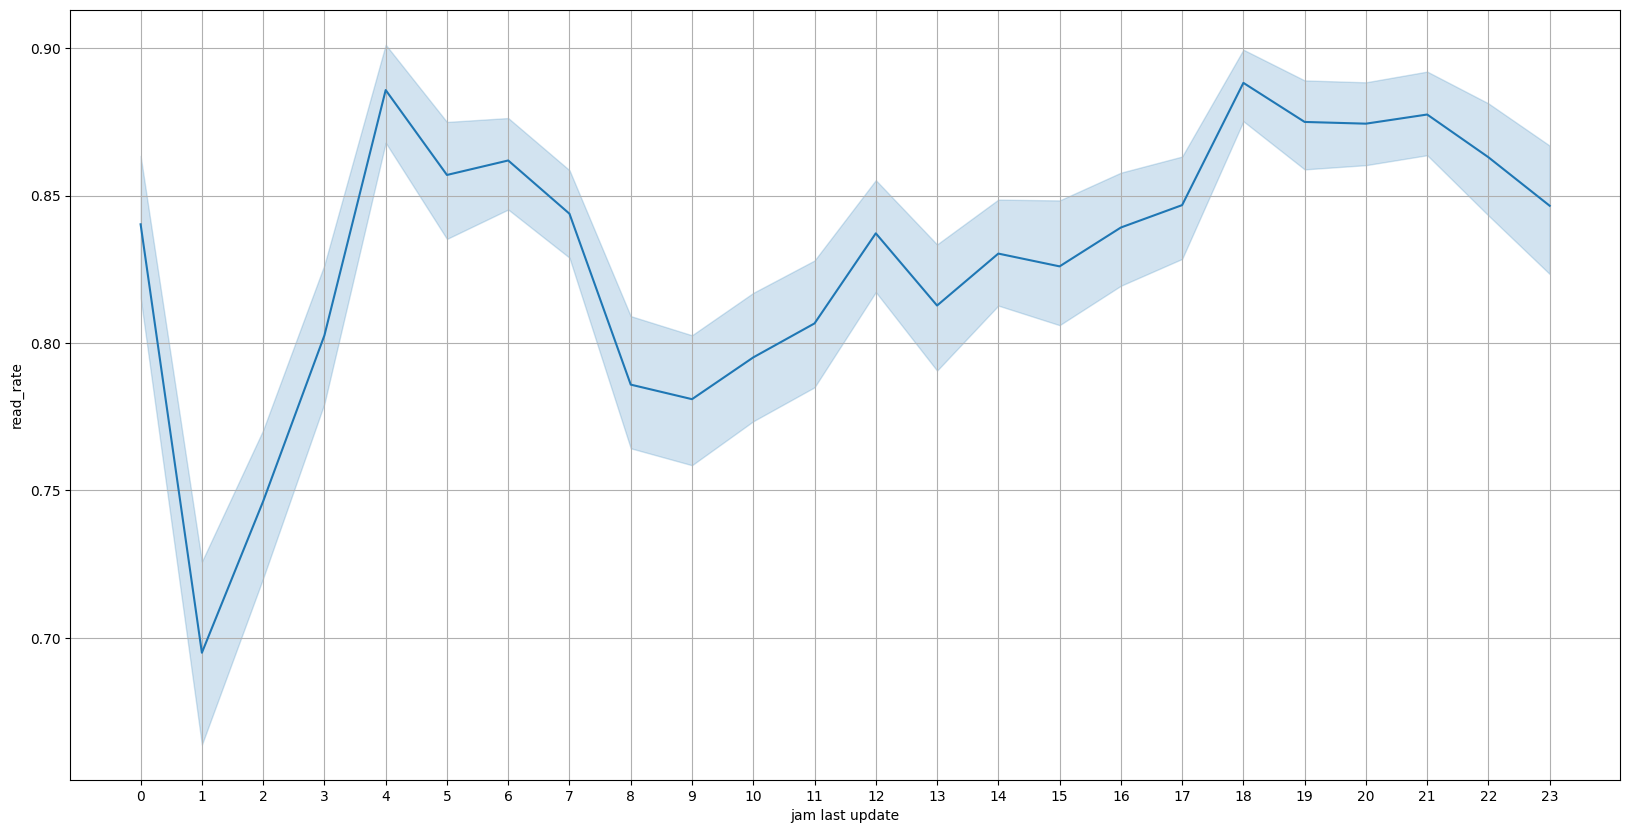

In [20]:
fig, ax = plt.subplots(figsize=(20,10))
# sns.barplot(x=groupby.jam, y=groupby['persentase_terbaca'], data=groupby, palette='Blues_d', ci=None, order=groupby.sort_values(by='persentase_terbaca', ascending=False).index, ax=ax)

sns.lineplot(data=groupby, y=groupby['read_rate'], x=groupby['jam last update'], ax=ax)
# sns.scatterplot(data=groupby, y=groupby['read_rate'], hue=groupby.hari, x=groupby.jam, ax=ax, legend=False)
plt.grid(True)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]);

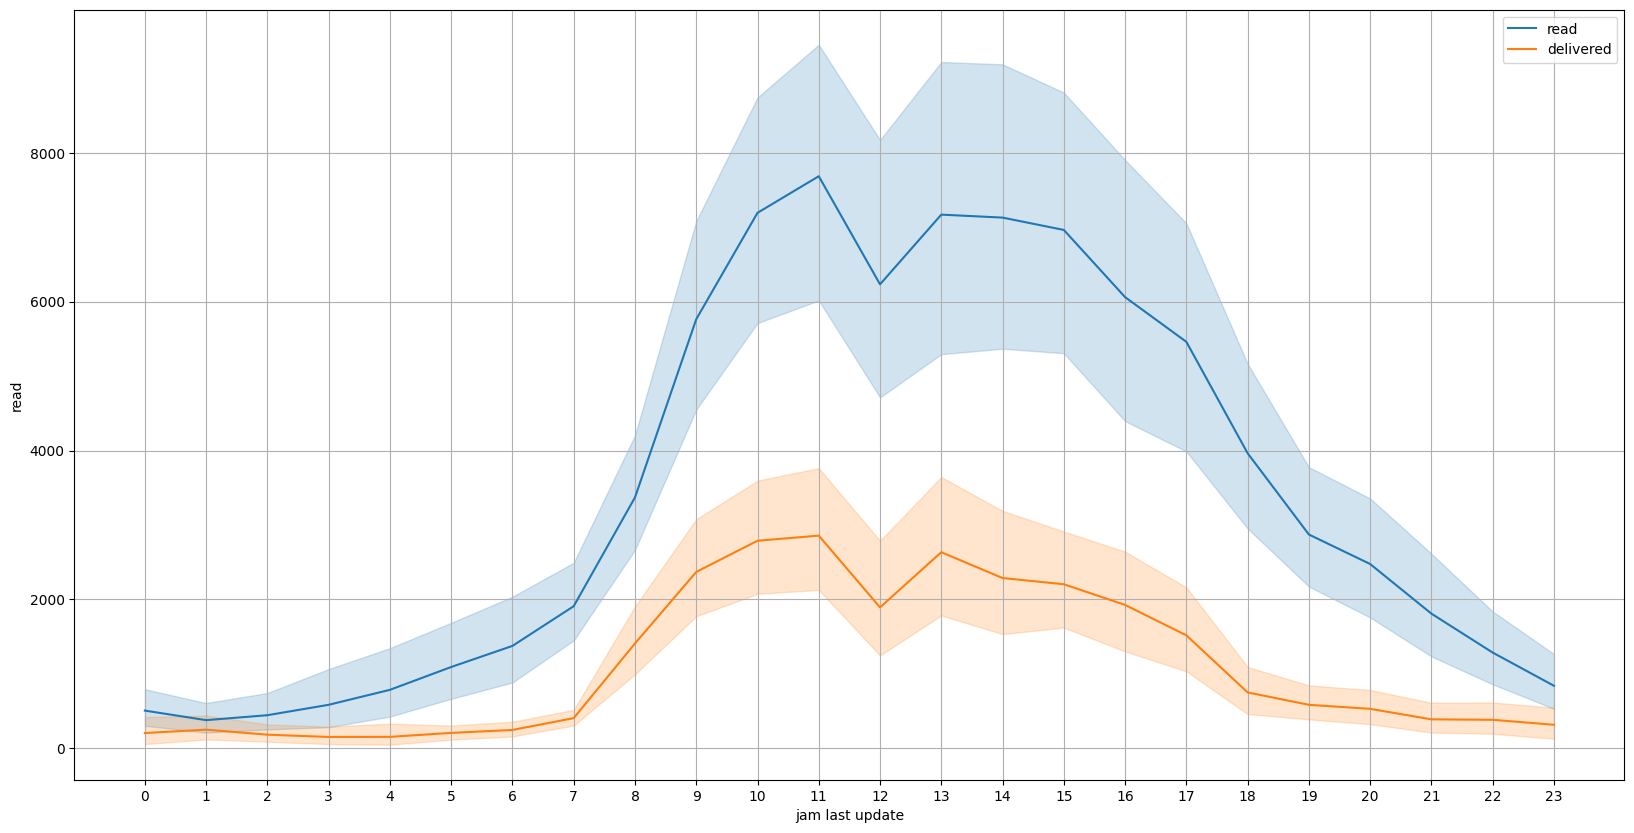

In [23]:
fig, ax = plt.subplots(figsize=(20,10))
# sns.barplot(x=groupby.jam, y=groupby['read_rate'], data=groupby, palette='Blues_d', ci=None, order=groupby.sort_values(by='read_rate', ascending=False).index, ax=ax)

sns.lineplot(data=groupby, y=groupby['read'],x=groupby['jam last update'], ax=ax, label='read')
sns.lineplot(data=groupby, y=groupby['delivered'], x=groupby['jam last update'], ax=ax, label='delivered')
plt.grid(True)
plt.xticks([0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]);

In [24]:
groupby.groupby(['jam last update']).sum().iloc[:,3:5]

C:\Users\Jayy\AppData\Local\Temp\ipykernel_3024\1024043572.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby.groupby(['jam last update']).sum().iloc[:,3:5]


Status,total,read_rate
jam last update,,
0,57738.0,68.060737
1,49780.0,54.901795
2,46542.0,55.227423
3,56093.0,60.996110
4,69595.0,65.547425
5,101426.0,66.844867
6,121756.0,64.642155
7,185231.0,67.506783
8,411016.0,67.586103


In [25]:
groupby.columns.shape

(12,)

In [26]:
# groupby.to_csv("../../data/data_olahan_groupby ada selisihnya 3.csv", index=False)

In [27]:
groupby.isnull().sum()

Status
hari last update       0
jam last update        0
tanggal last update    0
delivered              0
read                   0
total                  0
read_rate              0
read scalled           0
delivered scalled      0
weighted               0
is_weekend             0
is_working_hour        0
dtype: int64

In [28]:
groupby.dtypes

Status
hari last update        object
jam last update          int64
tanggal last update      int64
delivered              float64
read                   float64
total                  float64
read_rate              float64
read scalled           float64
delivered scalled      float64
weighted               float64
is_weekend              object
is_working_hour         object
dtype: object

In [29]:
groupby

Status,hari last update,jam last update,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted,is_weekend,is_working_hour
0,Sabtu,13,25,31393.0,64446.0,95839.0,0.672440,1.000000,1.000000,1.000000,Weekend,Non Working Hour
1,Sabtu,14,25,26926.0,61216.0,88142.0,0.694516,0.949880,0.857703,0.949788,Weekend,Non Working Hour
2,Sabtu,12,25,30938.0,57539.0,88477.0,0.650327,0.892823,0.985506,0.892916,Weekend,Non Working Hour
3,Sabtu,15,25,19051.0,52617.0,71668.0,0.734177,0.816448,0.606843,0.816239,Weekend,Non Working Hour
4,Sabtu,16,25,19326.0,50905.0,70231.0,0.724822,0.789883,0.615603,0.789709,Weekend,Non Working Hour
...,...,...,...,...,...,...,...,...,...,...,...,...
1967,Sabtu,14,29,1.0,3.0,4.0,0.750000,0.000031,0.000000,0.000031,Weekend,Non Working Hour
1968,Senin,13,8,1.0,3.0,4.0,0.750000,0.000031,0.000000,0.000031,Weekday,Working Hour
1969,Sabtu,2,22,2.0,2.0,4.0,0.500000,0.000016,0.000032,0.000016,Weekend,Non Working Hour
1970,Rabu,0,26,2.0,2.0,4.0,0.500000,0.000016,0.000032,0.000016,Weekday,Non Working Hour


In [30]:
groupby[(groupby['hari last update'] == 'Senin')].sort_values(by=['weighted'], ascending=False)

Status,hari last update,jam last update,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted,is_weekend,is_working_hour
9,Senin,16,20,10523.0,33441.0,43964.0,0.760645,0.518892,0.335181,0.518708,Weekday,Working Hour
13,Senin,15,20,12600.0,30265.0,42865.0,0.706054,0.469610,0.401344,0.469541,Weekday,Working Hour
26,Senin,14,27,7848.0,24213.0,32061.0,0.755217,0.375700,0.249968,0.375574,Weekday,Working Hour
35,Senin,11,27,8782.0,21329.0,30111.0,0.708346,0.330949,0.279721,0.330898,Weekday,Working Hour
39,Senin,11,20,8626.0,21156.0,29782.0,0.710362,0.328264,0.274752,0.328211,Weekday,Working Hour
...,...,...,...,...,...,...,...,...,...,...,...,...
1949,Senin,13,24,1.0,14.0,15.0,0.933333,0.000202,0.000000,0.000202,Weekday,Working Hour
1961,Senin,3,17,4.0,8.0,12.0,0.666667,0.000109,0.000096,0.000109,Weekday,Non Working Hour
1964,Senin,2,17,1.0,7.0,8.0,0.875000,0.000093,0.000000,0.000093,Weekday,Non Working Hour
1966,Senin,2,10,1.0,5.0,6.0,0.833333,0.000062,0.000000,0.000062,Weekday,Non Working Hour


In [31]:
groupby['rrw'] = (groupby['read_rate'] * 0.1) + (groupby['weighted'] * 0.9)

In [32]:
groupby.groupby('hari last update').sum()

C:\Users\Jayy\AppData\Local\Temp\ipykernel_3024\3845622757.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  groupby.groupby('hari last update').sum()


Status,jam last update,tanggal last update,delivered,read,total,read_rate,read scalled,delivered scalled,weighted,rrw
hari last update,,,,,,,,,,
Jumat,3255,4499,356240.0,1071681.0,1427921.0,228.982907,16.625060,11.339227,16.619774,37.856088
Kamis,3293,4256,292391.0,919070.0,1211461.0,231.588531,14.256994,9.305333,14.252043,35.985692
Minggu,3418,4050,171459.0,715268.0,886727.0,242.628568,11.094406,5.452663,11.088764,34.242745
Rabu,3290,4059,310587.0,972055.0,1282642.0,234.288340,15.079091,9.884811,15.073896,36.995341
Sabtu,3165,3872,540305.0,1411957.0,1952262.0,222.690862,21.905284,17.202918,21.900581,41.979609
Selasa,3344,4529,286211.0,950284.0,1236495.0,237.916037,14.741252,9.108276,14.735619,37.053661
Senin,3335,4264,299315.0,1003402.0,1302717.0,239.011340,15.565428,9.525580,15.559388,37.904583


In [33]:
groupby[(groupby['hari last update'] == 'Selasa')].drop(columns=['read scalled', 'delivered scalled']).sort_values(by='rrw', ascending=False)

Status,hari last update,jam last update,tanggal last update,delivered,read,total,read_rate,weighted,is_weekend,is_working_hour,rrw
19,Selasa,13,14,11170.0,26559.0,37729.0,0.703941,0.412047,Weekday,Working Hour,0.441236
16,Selasa,13,28,14850.0,26763.0,41613.0,0.643140,0.415327,Weekday,Working Hour,0.438108
25,Selasa,11,14,12898.0,24573.0,37471.0,0.655787,0.381316,Weekday,Working Hour,0.408763
34,Selasa,11,28,6996.0,21649.0,28645.0,0.755769,0.335801,Weekday,Working Hour,0.377798
49,Selasa,10,21,6593.0,19545.0,26138.0,0.747762,0.303173,Weekday,Working Hour,0.347632
...,...,...,...,...,...,...,...,...,...,...,...
1609,Selasa,3,3,83.0,113.0,196.0,0.576531,0.001739,Weekday,Non Working Hour,0.059218
1597,Selasa,1,3,89.0,119.0,208.0,0.572115,0.001832,Weekday,Non Working Hour,0.058860
1468,Selasa,4,17,159.0,192.0,351.0,0.547009,0.002966,Weekday,Non Working Hour,0.057370
1715,Selasa,1,24,73.0,78.0,151.0,0.516556,0.001196,Weekday,Non Working Hour,0.052732
